In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
def hop_1D(L,isPeriodic): #hopping in 1D with given boundary condition
    #L: number of lattice points
    #(clearly) based on your code 

    lattice = np.arange(L) #1D lattice

    cos = sp.sparse.dok_matrix((L,L), dtype=complex) #initialize matrices as sparse dok matrices
    sin = sp.sparse.dok_matrix((L,L), dtype=complex)

    for i in range(L):
        nextPos = lattice[(i+1)%L]
        doHop = isPeriodic or nextPos != 0
        if doHop:
            cos[i,nextPos] = 1/2
            sin[i,nextPos] = 1j/2 #j^2 = -1

    #we need not compute negative dir, just add hermitian adjoint
    cos += cos.conj().T
    sin += sin.conj().T

    return cos.toarray(), sin.toarray()

In [4]:
def hop_2D(L_y,L_x,isPerY,isPerX): #find cos, sin matrices for hopping in the dir of each axis; specify if either axis is periodic.
    #L_y: vertical size (n rows)
    #L_x: horizontal size (n cols)
    #isPerY,X: is periodic (boudnary cond) in respective direction?
    n_points = L_y*L_x
    lattice = np.arange(n_points).reshape((L_y,L_x))


    cosY = sp.sparse.dok_matrix((n_points,n_points), dtype=complex) #initialize matrices as sparse dok matrices
    sinY = sp.sparse.dok_matrix((n_points,n_points), dtype=complex)
    cosX = sp.sparse.dok_matrix((n_points,n_points), dtype=complex) 
    sinX = sp.sparse.dok_matrix((n_points,n_points), dtype=complex)

    for y in range(L_y):
        for x in range(L_x):

            y_nhbr = lattice[(y+1)%L_y, x] #next neighbor in positive vert dir (down)
            doHopY = isPerY or y_nhbr != 0 #only hop if periodic or next point is not wrapped 
            if doHopY:
                cosY[lattice[y,x], y_nhbr] = 1/2
                sinY[lattice[y,x], y_nhbr] = 1j/2


            x_nhbr = lattice[y, (x+1)%L_x] #next neighbor in positive hor dir (right)
            doHopX = isPerX or x_nhbr != 0
            if doHopX:
                cosX[lattice[y,x], x_nhbr] = 1/2
                sinX[lattice[y,x], x_nhbr] = 1j/2

    ver_list = [cosY, sinY]
    hor_list = [cosX, sinX]

    sup_list = [ver_list, hor_list] #idea to generalize to N dimensions

    for i in range(len(sup_list)): #for each axis of lattice
        for j in range(len(sup_list[i])): #for each cos, sin in given dir
            sup_list[i][j] += sup_list[i][j].conj().T #add hermitian adjoint (as opposed to also computing negative hop direction)
            sup_list[i][j] = sup_list[i][j].toarray() #convert to numpy array

    return sup_list

In [5]:
def init_cos_sin(n_points): 
    cos = sp.sparse.dok_matrix((n_points,n_points), dtype=np.csingle) #initialize matrices as sparse dok matrices
    sin = sp.sparse.dok_matrix((n_points,n_points), dtype=np.csingle)
    return cos, sin

In [6]:
def hop_ndim(shape,isPer): #generalization to n dimensions
    #shape: a tuple describing the size each dimension
    #isPer: a list of boolean with the same length as shape; is periodic in given dir?

    n_dims = len(shape)
    n_points = 1 #initalize
    for i in shape: #product of all dimension size
        n_points *= i

    lattice = np.arange(n_points).reshape(shape)

    super_list = [None]*n_dims #list of all cos, sin arrays

    for i in range(n_dims): #initalize cos, sin matrices
        
        super_list[i] = list(init_cos_sin(n_points)) #both for each direction


    for idx, value in np.ndenumerate(lattice): #for all lattice points
        for i in range(len(idx)): #each idx is a point; for each dimension 
            point = np.array(idx) #convert point to array 
            value = (point[i]+1)%(shape[i]) #find nearest neighbor in pos ith dir
            neighbor = point #initialize neighbor
            neighbor[i] = value #change ith coord. to neighboring value

            doHop = isPer[i] or value != 0 #check if hopping is allowed 
            if doHop:
                neighbor = tuple(neighbor)
                super_list[i][0][lattice[idx],lattice[neighbor]] = 1/2 #cos
                super_list[i][1][lattice[idx],lattice[neighbor]] = 1j/2 #sin

    for i in range(n_dims):
        for j in range(2):
            super_list[i][j] += super_list[i][j].conj().T #add hermitian adjoint
            super_list[i][j] = super_list[i][j].toarray() #conver to np array

    return super_list

In [7]:
def plot_eigenvalues(matrix,title): #self explanatory.
    eigvals = np.linalg.eigvalsh(matrix) #list of eigenvalues
    t = np.arange(len(eigvals))

    plt.figure(figsize=(10,2))
    plt.plot(t,eigvals)
    plt.xlabel('Nth lattice position')
    plt.ylabel('Eigenvalue')
    plt.title(title)
    plt.grid()
    plt.show()

def plot_all_eigvals(latticeShape,isPer,super_list): #will plot all eigenvalues of the super_list (not a generalized function)
    for i in range(len(latticeShape)):
        for j in range(2):
            namelist = ['cos', 'sin']
            title = f'Dim {i}; {namelist[j]}; periodic bound is {bool(isPer[i])}'
            plot_eigenvalues(super_list[i][j],title)

In [11]:
#ex to plot using hop_2D
#Define dimensions and boundary conditions
L_y = 10 #rows
L_x = 10 #columns
isPeriodicVert = False
isPeriodicHor = False
two_d_list = hop_2D(L_y,L_x,isPeriodicVert,isPeriodicHor)

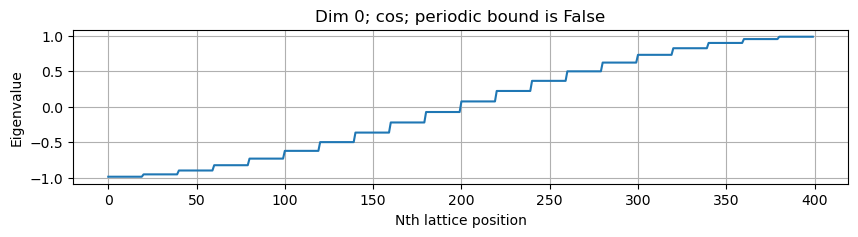

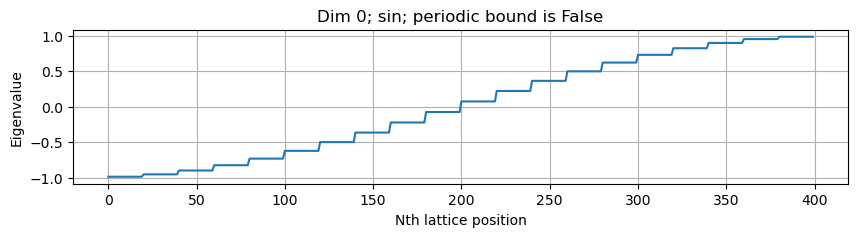

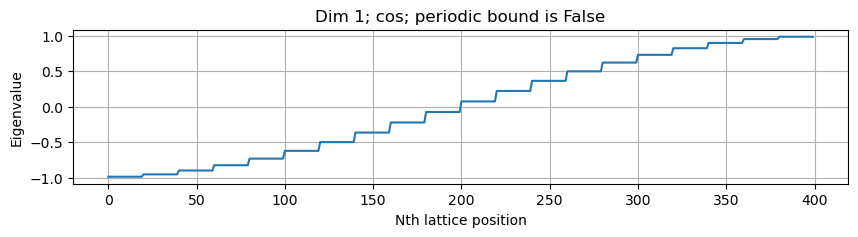

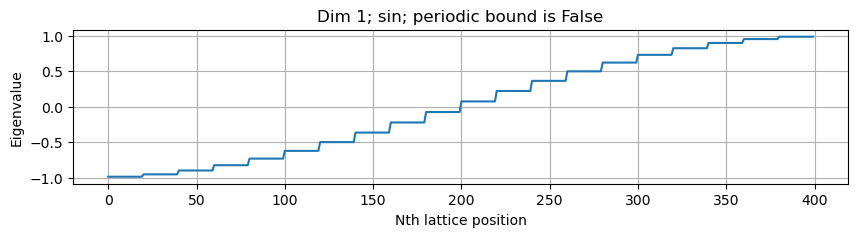

In [9]:
#example to plot
#clearly shows that the n-dimension generalization is pretty hungry in terms of memory
#my laptop cannot allocate more than ~750MB lols 
latticeShape = (20,20)
isPer = [0]*len(latticeShape)
super_list = hop_ndim(latticeShape,isPer)
plot_all_eigvals(latticeShape,isPer,super_list)